<a href="https://colab.research.google.com/github/KRP777X/Learning-Python-Physics-Informed-Machine-Learning-PINNs-DeepONets/blob/main/Financial_Data_Projector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tvdatafeed


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.1 MB/s 


In [ ]:
import numpy as np
import pandas as pd
#import yfinance as yf
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt                                                                          #Loading important libraries 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 12
from tvDatafeed import TvDatafeed, Interval
tv = TvDatafeed('aotleviackerman317','Sm$ge.L#e9FP5uF')

In [ ]:
ticker = ['SP:SPX']
lag = input('Value of Lags = ') # Only 1 or 2, But use 1 = Value of D                                       #Giving Values
Forecast_Years = int(input('Value of Years = '))


Value of Lags = 1
Value of Years = 960


In [ ]:
Names = []
for i in range(len(ticker)):
  Names.append('th{name}'.format(name = i))
gh = pd.DataFrame()
Data = []
for i in range(len(ticker)):                                                                                #importing data using TradingView library 
  th = tv.get_hist(symbol= ticker[i], n_bars = 10000000000, interval = Interval.in_monthly)
  gh[ticker[i]] = th['close']
  Data.append(gh)
df = Data[0]

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts):

  TR = []  

  for i in range(len(ticker)):
    hm = ts.iloc[:,i].to_frame()

    #Determining rolling statistics

    MovingAverage = hm.rolling(window = 5).mean()
    MovingSTD = hm.rolling(window = 5).std()

    #Plot rolling statistics
   
    plt.figure(figsize = (4,3))
    plt.title('Rolling mean and STD')
    plt.plot(hm, color= 'blue', label = 'Price')
    plt.plot(MovingAverage, color= 'red', label = 'MA')                                                                             #Adfuller test code
    plt.plot(MovingSTD, color= 'black', label = 'STD')
    plt.legend(loc = 'best')
    plt.grid()
    plt.show()

    #Perform Dickey fuller test

    print('Results of dickey fuller test {name}'.format(name = ticker[i]))
    dftest = adfuller(hm, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistics', 'P Value', 'Lags Used', 'Number of observations used'])

    for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value

    TR.append(dfoutput)

  TR = pd.DataFrame(TR, index = ticker)
  print(TR)

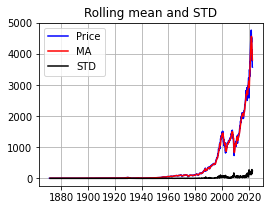

Results of dickey fuller test SP:SPX
        Test Statistics  P Value  Lags Used  Number of observations used  \
SP:SPX         4.550768      1.0       22.0                       1528.0   

        Critical Value (1%)  Critical Value (5%)  Critical Value (10%)  
SP:SPX            -3.434637            -2.863433             -2.567778  


In [ ]:
test_stationarity(df)

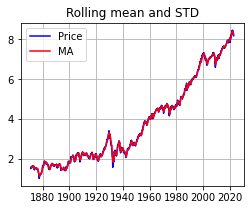

In [ ]:
dflogscale = []
for i in range(len(ticker)):

  hf = df.iloc[:,i]
  
  df_logscale = np.log(hf)
  movingaveragelog = df_logscale.rolling(window = 5).mean()
  dflogscale.append(df_logscale)
                                                                                                 #Checking stationarity of the log graph
  plt.figure(figsize = (4,3))
  plt.title('Rolling mean and STD')
  plt.plot(df_logscale, color= 'blue', label = 'Price')
  plt.plot(movingaveragelog, color= 'red', label = 'MA')
  plt.legend(loc = 'best')
  plt.grid()
  plt.show()

In [ ]:
dflogscale = pd.DataFrame(dflogscale)
dflogscale = dflogscale.transpose()


In [ ]:
df_logdiffshift = dflogscale - dflogscale.shift()
df_logdiffshift.dropna(inplace = True)

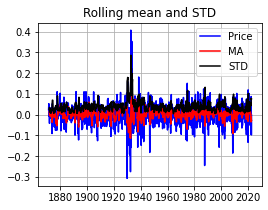

Results of dickey fuller test SP:SPX
        Test Statistics       P Value  Lags Used  Number of observations used  \
SP:SPX       -12.445291  3.676175e-23        8.0                       1541.0   

        Critical Value (1%)  Critical Value (5%)  Critical Value (10%)  
SP:SPX            -3.434601            -2.863417             -2.567769  


In [ ]:
test_stationarity(df_logdiffshift)                                                                   #Checking stationarity with lag = 1, Now the data is stationary 

In [ ]:
df_logdiffshift2 = df_logdiffshift - df_logdiffshift.shift()
df_logdiffshift2.dropna(inplace = True)

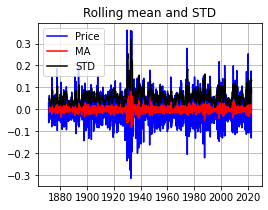

Results of dickey fuller test SP:SPX
        Test Statistics       P Value  Lags Used  Number of observations used  \
SP:SPX       -13.954663  4.634748e-26       24.0                       1524.0   

        Critical Value (1%)  Critical Value (5%)  Critical Value (10%)  
SP:SPX            -3.434648            -2.863438             -2.567781  


In [ ]:
test_stationarity(df_logdiffshift2)                                                                  #Checking stationarity with lag = 2

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


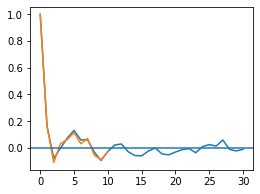

In [ ]:
#ACF and PACF PLOT
ACF = []
PACF = []

for i in range(len(ticker)):

  from statsmodels.tsa.stattools import acf , pacf

  lag_acf = acf(df_logdiffshift.iloc[:, i], nlags=30)
  lag_pacf = pacf(df_logdiffshift.iloc[:, i], nlags=10, method = 'ols')

  ACF.append(lag_acf)
  PACF.append(lag_pacf)

  plt.figure(figsize = (4,3))
  plt.plot(lag_acf)
  plt.plot(lag_pacf)
  plt.axhline(y=0)

In [ ]:
AP = pd.DataFrame(ACF)
AP = AP.transpose()
PP = pd.DataFrame(PACF)
PP = PP.transpose()

In [ ]:
#Finding P and Q value
Final_ACF = []
for z in range(len(ticker)):
  ER = AP.iloc[:,z].to_list()
  for i in ER:
    if i<0:
      Final_ACF.append(ER.index(i))
      break
Final_PACF = []
for z in range(len(ticker)):
  EN = PP.iloc[:,z].to_list()
  for i in EN:
    if i<0:
      Final_PACF.append(EN.index(i))
      break

In [ ]:
Final_ACF

[2]

In [ ]:
Final_PACF

[2]

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

hsd = []

for i in range(len(ticker)):

  p = int(Final_ACF[i])
  q = int(Final_PACF[i])
  d = int(lag)

  isd = dflogscale.iloc[:,i].to_frame()

  model = ARIMA(isd, order = (p, d, q))
  results_AR = model.fit(transparams=False)                              #Fitting the model

  e = int(Forecast_Years)

  tf = results_AR.forecast(e)
  tf = np.exp(tf[0])
  hsd.append(tf)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

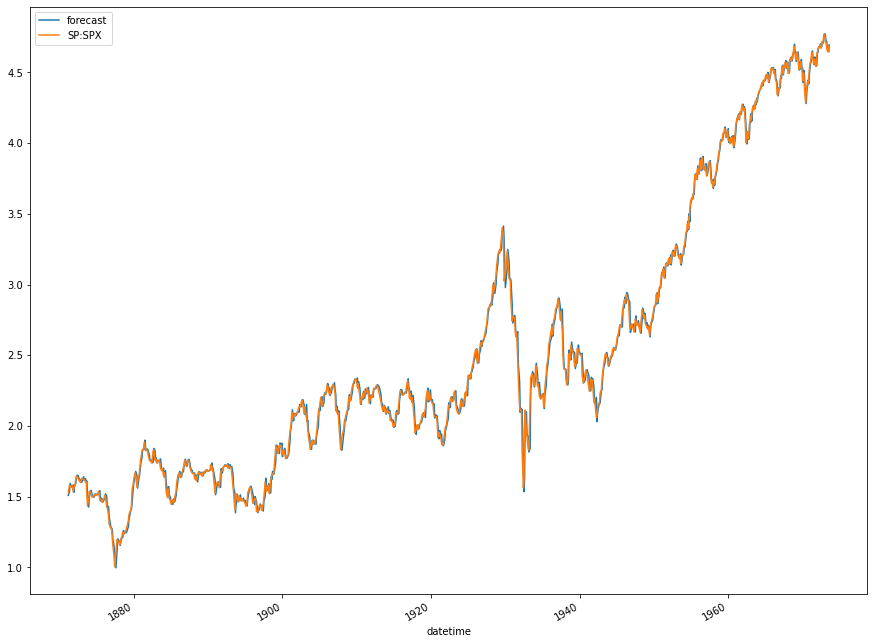

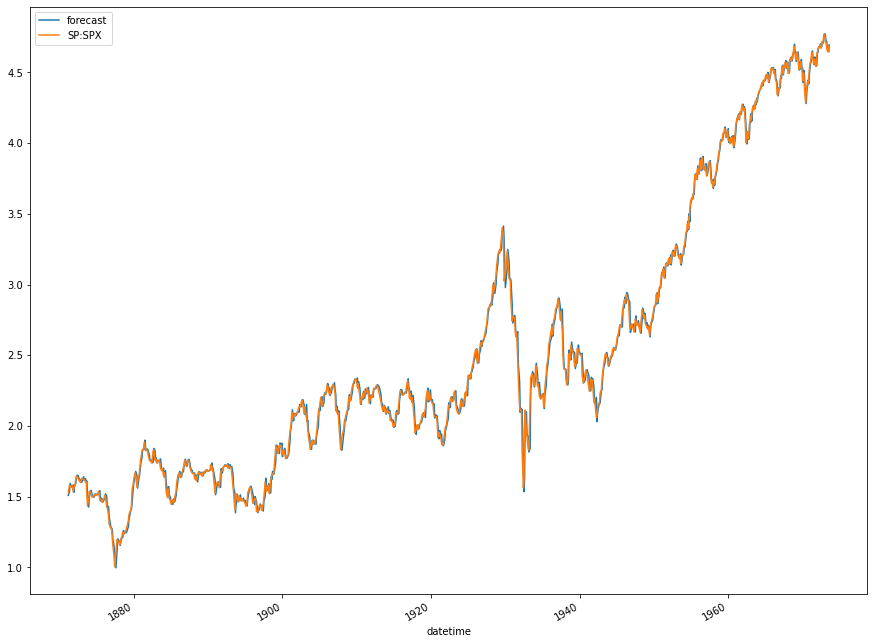

In [ ]:
results_AR.plot_predict(end = Forecast_Years)

In [ ]:
print(results_AR.summary())


                             ARIMA Model Results                              
Dep. Variable:               D.SP:SPX   No. Observations:                 1550
Model:                 ARIMA(2, 1, 2)   Log Likelihood                2522.320
Method:                       css-mle   S.D. of innovations              0.048
Date:                Thu, 13 Oct 2022   AIC                          -5032.641
Time:                        04:44:13   BIC                          -5000.565
Sample:                             1   HQIC                         -5020.711
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0043      0.002      2.839      0.005       0.001       0.007
ar.L1.D.SP:SPX     0.4142      0.165      2.517      0.012       0.092       0.737
ar.L2.D.SP:SPX     0.3311      0.107

In [ ]:
Year = []

for i in range(2022, 2022+Forecast_Years, 1):
  Year.append(i)

In [ ]:
hsd = pd.DataFrame(hsd)
hsd = hsd.transpose()
Final_Prediction = hsd

In [ ]:
Final_Prediction['Years'] = Year
SG= Final_Prediction.set_index('Years')

In [ ]:
SG.columns = ticker
SG

,SP:SPX
Years,
2022,3587.402330
2023,3591.650214
2024,3600.796659
2025,3609.957155
2026,3620.766988
...,...
2977,215088.127289
2978,216015.267478
2979,216946.404117


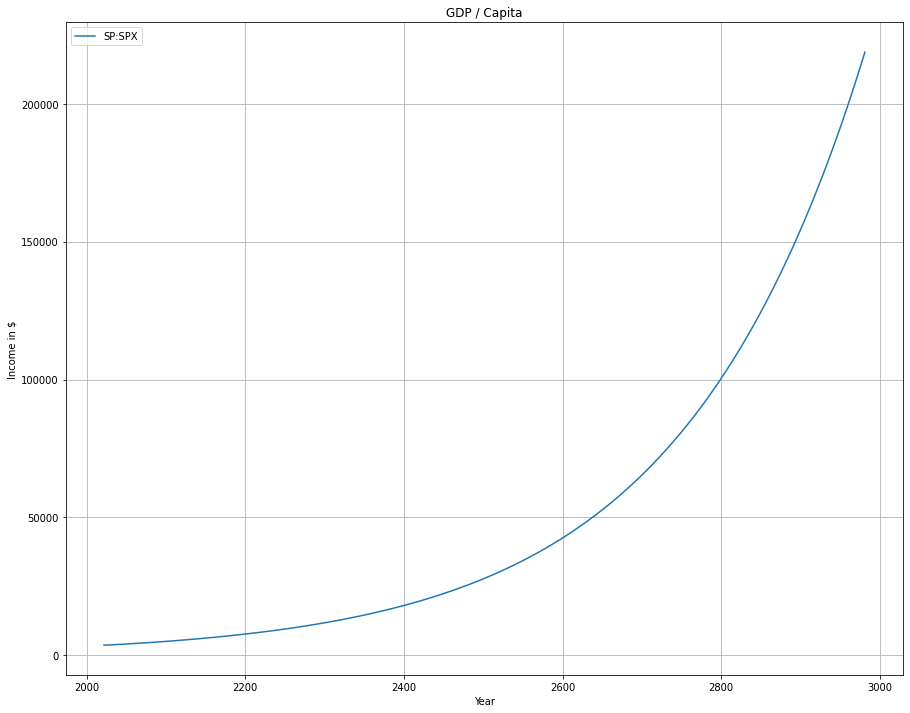

In [ ]:
SG.plot(label = 'ticker')
plt.title('GDP / Capita')
plt.xlabel('Year')
plt.ylabel('Income in $')                                                               #Plotting Projections
plt.legend(loc= 'upper left')
plt.grid(True)
plt.show()